# Seq2Seq Autoencoder

## 导入库

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import pandas as pd

## 超参

In [2]:
TRAIN_BUF=60000
BATCH_SIZE=512
TEST_BUF=10000
DIMS = (28, 28, 1)
N_Z = 128
SHAPE_FINAL = (7,7,64)
EPOCH = 100

## 导入数据

In [3]:
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

## 数据处理 

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32") / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

## tf封装数据

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)

## 生成标签

In [6]:
enc = [
    keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation="relu", padding="same"),
    keras.layers.Conv2D(filters=SHAPE_FINAL[2], kernel_size=3, strides=(2, 2), activation="relu", padding="same"),
    keras.layers.Reshape(target_shape=(SHAPE_FINAL[0], np.prod(SHAPE_FINAL[1:]))),
    keras.layers.Bidirectional(keras.layers.LSTM(units=100, activation="relu")),
    keras.layers.Dense(units=512),
    keras.layers.Dense(units=N_Z),
]

## 生成图片

In [7]:
dec = [
    keras.layers.Dense(units=512),
    keras.layers.RepeatVector(SHAPE_FINAL[0]),
    keras.layers.Bidirectional(keras.layers.LSTM(units=100, activation="relu", return_sequences=True)),
    keras.layers.TimeDistributed(keras.layers.Dense(np.prod(SHAPE_FINAL[1:]))),
    keras.layers.Reshape(target_shape=(SHAPE_FINAL[0], SHAPE_FINAL[1], SHAPE_FINAL[2])),
    keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"),
    keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"),
    keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"),
    keras.layers.Reshape(target_shape=(28, 28, 1)),
]

## 模型定义

In [8]:
class AE(tf.keras.Model):
    def __init__(self, **kwargs):
        super(AE, self).__init__()
        self.__dict__.update(kwargs)
         
        self.enc = tf.keras.Sequential(self.enc)
        self.dec = tf.keras.Sequential(self.dec)

    @tf.function
    def encode(self, x):
        return self.enc(x)

    @tf.function
    def decode(self, z):
        return self.dec(z)
    
    @tf.function
    def compute_loss(self, x):
        z = self.encode(x)
        _x = self.decode(z)
        ae_loss = tf.reduce_mean(tf.square(x - _x))
        return ae_loss
    
    @tf.function
    def compute_gradients(self, x):
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x)
        return tape.gradient(loss, self.trainable_variables)

    @tf.function
    def train(self, train_x):    
        gradients = self.compute_gradients(train_x)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

## 优化器

In [9]:
optimizer = keras.optimizers.Adam(1e-3, beta_1=0.5)

## 加载模型

In [10]:
model = AE(enc=enc, dec=dec, optimizer=optimizer)

## 存储损失

In [11]:
losses = pd.DataFrame(columns = ['MSE'])

## 绘制

In [12]:
example_data = next(iter(test_dataset))

def plot_reconstruction(model, example_data, nex=5, zm=2):
    example_data_reconstructed = model.decode(model.encode(example_data))
    fig, axs = plt.subplots(ncols=nex, nrows=2, figsize=(zm * nex, zm * 2))
    for exi in range(nex):
        axs[0, exi].matshow(example_data.numpy()[exi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1)
        axs[1, exi].matshow(example_data_reconstructed.numpy()[exi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1,)
    for ax in axs.flatten():
        ax.axis("off")
    plt.show()

## 训练

Epoch: 99 | MSE: 0.008478136733174324


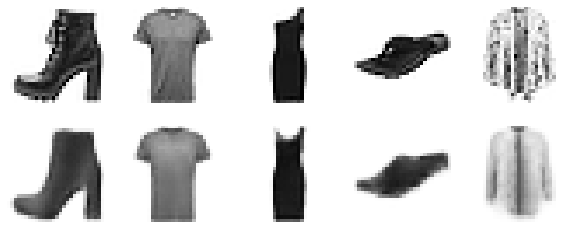

In [13]:
for epoch in range(EPOCH):
    for batch, train_x in enumerate(train_dataset):
        model.train(train_x)
    loss = []
    for batch, test_x in enumerate(test_dataset):
        loss.append(model.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    display.clear_output()
    print("Epoch: {} | MSE: {}".format(epoch, losses.MSE.values[-1]))
    plot_reconstruction(model, example_data)

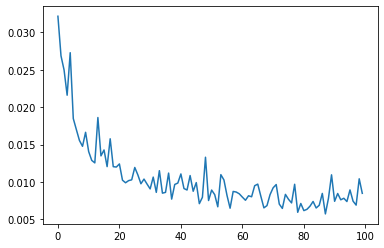

In [14]:
plt.plot(losses.MSE.values)

In [15]:
model.save_weights('./save/save_weights/model_weights.h5')